In [ ]:
# !pip install sentence_transformers
# !pip install keras_tuner
# !pip install python-louvain

# from google.colab import drive
# drive.mount('/content/drive')


import csv
import json
import re
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import normalized_mutual_info_score
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NearestCentroid
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,accuracy_score,ConfusionMatrixDisplay,precision_score,recall_score,f1_score,pairwise_distances
from sklearn.preprocessing import normalize
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import plotly.graph_objects as go
import plotly.express as px
import networkx as nx
import networkx.algorithms.community as nx_comm
from community import community_louvain
from ast import literal_eval
np.set_printoptions(linewidth=25000)

In [ ]:
rawData = []

with open("./booksummaries/booksummaries.txt", 'r') as originalData:
    data = csv.reader(originalData, dialect='excel-tab')
    for row in data:
        rawData.append(row)

#print(rawData[245])
#print(len(rawData))

In [ ]:
index = range(len(rawData))

book_data = [[idx,r[0],r[2],r[3],r[4],r[5],r[6]] for idx, r in zip(index, rawData)]

#book_data[0]

df = pd.DataFrame(book_data,columns =['Index','ID','BookTitle','Author','PubDate','Genres_','Summary_'])

#df.info()
df.head(10)

In [ ]:
df = df.drop(df[df['Genres_'] == ''].index)
df = df.drop(df[df['Summary_'] == ''].index)

genres_data = []
for g in df['Genres_']:
    genres_data.append(list(json.loads(g).values()))

df['Genres'] = genres_data

genres_list = [i for l in df['Genres'] for i in l]
genres_size = [len(l) for l in df['Genres']]
genre_count = pd.value_counts(genres_list)

df['Genres_Size'] = genres_size

In [ ]:
summary_size = [len(l.split(' ')) for l in df['Summary_']]
summary_char = [re.search(r'[^\w\d\s:.,!?]', l) for l in df['Summary_']]

summary_text = []
for s in df['Summary_']:
    summary_text.append(re.sub(r'[^\w\d\s:.,!?]',' ',s))

df['Summary'] = summary_text
df['Summary_Size'] = summary_size

print("Gêneros distintos: ",len(genre_count),"\nContagem de palavras dos sumários, máx ", \
                             max(summary_size)," e mín ",min(summary_size))

In [ ]:
df.head(10)

In [ ]:
#genre_count.head(20)
selected_genres = ['Science Fiction','Novel','Fantasy',"Children's literature","Mystery"]

In [ ]:
plt.hist(genres_size,rwidth=0.85)
plt.xlabel('Gêneros')
plt.ylabel('Frequência')
plt.title('Distribuição da quantidade de gêneros')
plt.show()


plt.hist(summary_size,np.linspace(0,1500,50),rwidth=0.85)
plt.xlabel('Sumário')
plt.ylabel('Frequência')
plt.title('Distribuição do tamanho em palavras dos sumários')
plt.show()

In [ ]:
df_select = df.drop(df[df['Summary_Size'] > 400].index)
df_select = df_select.drop(df_select[df_select['Summary_Size'] < 50].index)
df_select = df_select.drop(df_select[df_select['Genres_Size'] > 5].index)
df_select = df_select.drop(columns=['Index', 'Genres_', 'Summary_'])
df_select = df_select.reset_index()

df_genre = pd.DataFrame(df_select['Genres'].tolist(),columns=['G1', 'G2', 'G3', 'G4', 'G5'])

df_select = pd.concat([df_select, df_genre], axis = 1)
df_select.loc[~df_select['G1'].isin(selected_genres),'G1'] = 'None'
df_select.loc[~df_select['G2'].isin(selected_genres),'G2'] = 'None'
df_select.loc[~df_select['G3'].isin(selected_genres),'G3'] = 'None'
df_select.loc[~df_select['G4'].isin(selected_genres),'G4'] = 'None'
df_select.loc[~df_select['G5'].isin(selected_genres),'G5'] = 'None'

df_ready = df_select[df_select[['G1','G2','G3','G4','G5']].isin(selected_genres).any(axis = 1)].copy()

def arruma(x):
    if x['G4'] == 'None':
        x['G4'] = x['G5']
        x['G5'] = 'None'
    if x['G3'] == 'None':
        x['G3'] = x['G4']
        x['G4'] = x['G5']
        x['G5'] = 'None'
    if x['G2'] == 'None':
        x['G2'] = x['G3']
        x['G3'] = x['G4']
        x['G4'] = x['G5']
        x['G5'] = 'None'
    if x['G1'] == 'None':
        x['G1'] = x['G2']
        x['G2'] = x['G3']
        x['G3'] = x['G4']
        x['G4'] = x['G5']
        x['G5'] = 'None'
    return x

df_ready = df_ready.apply(lambda x: arruma(x), axis=1)
df_ready['Genres_Class_Size'] = df_ready[df_ready[['G1','G2','G3','G4','G5']].isin(selected_genres)].count(axis=1)


def numera(genres):
    resp = []
    for x in genres:
        if x in selected_genres:
            resp.append(selected_genres.index(x))
    return resp

df_ready['Genre_Class'] = df_ready[['G1','G2','G3','G4','G5']].apply(lambda x: numera(x), axis=1)



plt.hist(df_ready['Genres_Class_Size'],[0.5,1.5,2.5,3.5,4.5,5.5],rwidth=0.85)
plt.xlabel('Gêneros')
plt.ylabel('Frequência')
plt.title('Distribuição da quantidade de gêneros')
plt.show()

df_ready.info()

In [ ]:
df_ready_1g = df_ready[df_ready['Genres_Class_Size'] == 1].copy()
df_ready_ag = df_ready[df_ready['Genres_Class_Size'] > 1].copy()

df_ready_1g.info()
df_ready_ag.info()

In [ ]:
plt.hist(df_ready['Genres_Size'],[0.5,1.5,2.5,3.5,4.5,5.5],rwidth=0.85)
plt.xlabel('Gêneros')
plt.ylabel('Frequência')
plt.title('Distribuição da quantidade de gêneros')
plt.show()


plt.hist(df_ready['Summary_Size'],np.linspace(50,450,20),rwidth=0.85)
plt.xlabel('Sumário')
plt.ylabel('Frequência')
plt.title('Distribuição do tamanho em palavras dos sumários')
plt.show()

In [ ]:
df_train, df_test = train_test_split(df_ready_1g, test_size=0.3, random_state=99)

df_train = df_train.copy()
df_test = df_test.copy()

df_train.head()

In [ ]:
model = SentenceTransformer('/content/drive/MyDrive/TCC/finetune-test')
model.max_seq_length = 512
print("Max Sequence Length:", model.max_seq_length)

Max Sequence Length: 512


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/TCC/df_train.txt')
df_test = pd.read_csv('/content/drive/MyDrive/TCC/df_test.txt')

df_train = df_train.drop(columns=['Embedding'])
df_test = df_test.drop(columns=['Embedding'])

def embedding(x):
    return model.encode(x)
    
df_train['Embedding'] = df_train['Summary'].apply(lambda x: embedding(x))

df_train.to_csv('/content/drive/MyDrive/TCC/df_train_new.txt')


df_test['Embedding'] = df_test['Summary'].apply(lambda x: embedding(x))

df_test.to_csv('/content/drive/MyDrive/TCC/df_test_new.txt')


In [ ]:
###########################################################
######################começa aqui##########################
###########################################################


1    754
0    664
3    453
2    406
4    400
Name: Genre_Class, dtype: int64
1    348
0    233
3    192
2    192
4    183
Name: Genre_Class, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2677 entries, 0 to 2676
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         2677 non-null   int64 
 1   Unnamed: 0.1       2677 non-null   int64 
 2   index              2677 non-null   int64 
 3   ID                 2677 non-null   int64 
 4   BookTitle          2677 non-null   object
 5   Author             2476 non-null   object
 6   PubDate            1987 non-null   object
 7   Genres             2677 non-null   object
 8   Genres_Size        2677 non-null   int64 
 9   Summary            2677 non-null   object
 10  Summary_Size       2677 non-null   int64 
 11  G1                 2677 non-null   object
 12  G2                 2677 non-null   object
 13  G3                 2677 non-n

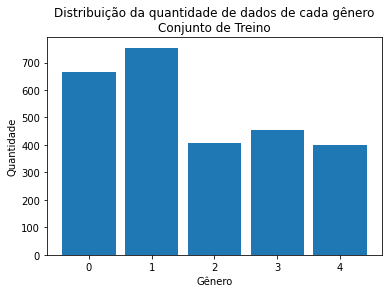

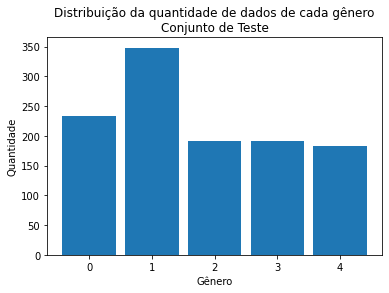

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/TCC/df_train_new.txt')
df_test = pd.read_csv('/content/drive/MyDrive/TCC/df_test_new.txt')

def limpa(x):
    return [float(n) for n in (x.strip('[]').replace(' ',',').replace(',,',',').split(',')) if n != '' ]

df_train['Embedding'] = df_train['Embedding'].apply(lambda x: limpa(x))
df_test['Embedding'] = df_test['Embedding'].apply(lambda x: limpa(x))

def limpa2(x):
    return int(x.strip('[]'))

df_train['Genre_Class'] = df_train['Genre_Class'].apply(lambda x: limpa2(x))
df_test['Genre_Class'] = df_test['Genre_Class'].apply(lambda x: limpa2(x))

print(df_train['Genre_Class'].value_counts())
print(df_test['Genre_Class'].value_counts())

def lista(x):
    return [x]

ohe = OneHotEncoder(sparse=False)
ohe_train = pd.Series(list(ohe.fit_transform(df_train['Genre_Class'].apply(lambda x: lista(x)).tolist())))
ohe_test = pd.Series(list(ohe.fit_transform(df_test['Genre_Class'].apply(lambda x: lista(x)).tolist())))

df_train['ohe_train'] = ohe_train
df_test['ohe_test'] = ohe_test

df_train.info()
df_test.info()

plt.hist(df_train['Genre_Class'],[-0.5,0.5,1.5,2.5,3.5,4.5],rwidth=0.85)
plt.xlabel('Gênero')
plt.ylabel('Quantidade')
plt.title("Distribuição da quantidade de dados de cada gênero\nConjunto de Treino")
plt.show()

plt.hist(df_test['Genre_Class'],[-0.5,0.5,1.5,2.5,3.5,4.5],rwidth=0.85)
plt.xlabel('Gênero')
plt.ylabel('Quantidade')
plt.title('Distribuição da quantidade de dados de cada gênero\nConjunto de Teste')
plt.show()



In [ ]:
df_train[df_train['Author'].str.contains("Lewis", na=False)]


Unnamed: 0  Unnamed: 0.1  index       ID                      BookTitle  \
2243        2243          2840   6970  5870991  Young Fu of the Upper Yangtze   

               Author PubDate                                Genres  \
2243  Elizabeth Lewis    1932  ["Children's literature", 'Fiction']   

      Genres_Size                                            Summary  \
2243            2   As the book opens, the widowed Fu Be be arriv...   

      Summary_Size                     G1    G2    G3    G4    G5  \
2243           163  Children's literature  None  None  None  None   

      Genres_Class_Size  Genre_Class  \
2243                  1            3   

                                              Embedding  \
2243  [-0.0155072641, 0.00986672658, -0.0265764259, ...   

                      ohe_train  
2243  [0.0, 0.0, 0.0, 1.0, 0.0]

0    400
1    400
2    400
3    400
4    400
Name: Genre_Class, dtype: int64


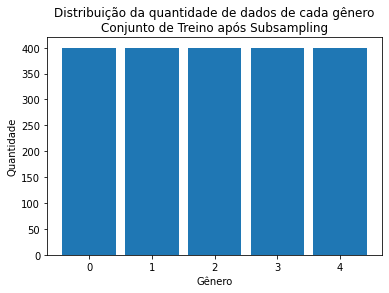

In [ ]:
rus = RandomUnderSampler(random_state=666)
df_train_rus,_ = rus.fit_resample(df_train,df_train['Genre_Class'].tolist())
print(df_train_rus['Genre_Class'].value_counts())

df_train = df_train_rus.copy()

plt.hist(df_train_rus['Genre_Class'],[-0.5,0.5,1.5,2.5,3.5,4.5],rwidth=0.85)
plt.xlabel('Gênero')
plt.ylabel('Quantidade')
plt.title('Distribuição da quantidade de dados de cada gênero\nConjunto de Treino após Subsampling')
plt.show()

In [ ]:

#['Science Fiction','Novel','Fantasy',"Children's literature","Mystery"]
#["The Quantum Rose","Prayer for the Living","Oracle's Queen","The Sly Old Cat", "Manalive"]
#[azul, roxo , vermelho, laranja, amarelo]

df_train[df_train['BookTitle']=="Oracle's Queen"]

Unnamed: 0  Unnamed: 0.1  index       ID       BookTitle  \
1149        1453          3193   7743  7074872  Oracle's Queen   

               Author     PubDate                              Genres  \
1149  Lynn Flewelling  2006-05-02  ['Speculative fiction', 'Fantasy']   

      Genres_Size                                            Summary  \
1149            2   More and more people flock to Tamír s cause a...   

      Summary_Size       G1    G2    G3    G4    G5  Genres_Class_Size  \
1149           132  Fantasy  None  None  None  None                  1   

      Genre_Class                                          Embedding  \
1149            2  [0.00524186622, -0.0340950042, 0.0229450427, 0...   

                      ohe_train  
1149  [0.0, 0.0, 1.0, 0.0, 0.0]

In [ ]:
#acc = []
#for n in range(1,40):
n = 13
train_classifier = KNeighborsClassifier(n_neighbors = n, metric = 'euclidean')
train_classifier.fit(np.array(df_train['Embedding'].tolist()), np.array(df_train['Genre_Class'].tolist()))

y_pred = train_classifier.predict(np.array(df_test['Embedding'].tolist()))


cm = confusion_matrix(np.array(df_test['Genre_Class'].tolist()), y_pred)
ac = accuracy_score(np.array(df_test['Genre_Class'].tolist()),y_pred)
#    acc.append([n,ac])



print(cm)
print(ac)
#or i in acc:
#    print(i)

[[192  11  18   3   9]
 [ 20 245   9  39  35]
 [ 13  12 156   3   8]
 [  5  13  27 138   9]
 [  5  15   6   5 152]]
0.769163763066202


0    183
1    183
2    183
3    183
4    183
Name: Genre_Class, dtype: int64
[[149   9  16   3   6]
 [  9 131   6  22  15]
 [ 12  10 150   3   8]
 [  5  13  24 133   8]
 [  5  15   6   5 152]]
0.7814207650273224
[0.82777778 0.73595506 0.74257426 0.80120482 0.8042328 ]
[0.81420765 0.71584699 0.81967213 0.72677596 0.83060109]
[0.82093664 0.72576177 0.77922078 0.76217765 0.8172043 ]


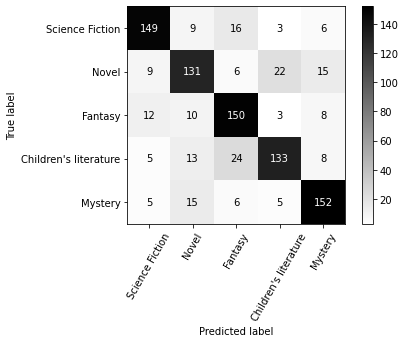

In [ ]:
rus_test = RandomUnderSampler(random_state=666)
df_test_rus,_ = rus_test.fit_resample(df_test,df_test['Genre_Class'].tolist())

print(df_test_rus['Genre_Class'].value_counts())

y_pred = train_classifier.predict(np.array(df_test_rus['Embedding'].tolist()))


cm = confusion_matrix(np.array(df_test_rus['Genre_Class'].tolist()), y_pred)
ac = accuracy_score(np.array(df_test_rus['Genre_Class'].tolist()),y_pred)

print(cm)
print(ac)

print(precision_score(np.array(df_test_rus['Genre_Class'].tolist()), y_pred, average=None))
print(recall_score(np.array(df_test_rus['Genre_Class'].tolist()), y_pred, average=None))
print(f1_score(np.array(df_test_rus['Genre_Class'].tolist()), y_pred, average=None))

disp = ConfusionMatrixDisplay.from_predictions(np.array(df_test_rus['Genre_Class'].tolist()), y_pred, display_labels=selected_genres, xticks_rotation=60, cmap="gist_yarg")


In [ ]:
train_graph = nx.Graph(train_classifier.kneighbors_graph())

pos = nx.spring_layout(train_graph, seed=42)

for node in train_graph.nodes():
    train_graph.nodes[node]['pos'] = pos[node]


def show_graph(G,color):
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=2, color='#888'),
        hoverinfo='none',
        mode='lines')
    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        hovertext=df_train['BookTitle'].tolist(),
        marker=dict(
            size=10,
            line_width=2,
            color=color))
    fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    fig.show()
    


In [ ]:
show_graph(train_graph, df_train['Genre_Class'].tolist())

In [ ]:
train_centroid = NearestCentroid()
train_centroid.fit(np.array(df_train['Embedding'].tolist()), np.array(df_train['Genre_Class'].tolist()))
train_centroid.score(np.array(df_test['Embedding'].tolist()), np.array(df_test['Genre_Class'].tolist()))


sumario_foundation = """For twelve thousand years the Galactic Empire has ruled supreme. Now it is dying. But only Hari Seldon, creator of the revolutionary science of psychohistory, can see into the future -- to a dark age of ignorance, barbarism, and warfare that will last thirty thousand years. To preserve knowledge and save mankind, Seldon gathers the best minds in the Empire both scientists and scholars and brings them to a bleak planet at the edge of the Galaxy to serve as a beacon of hope for a future generations. He calls his sanctuary the Foundation.But soon the fledgling Foundation finds itself at the mercy of corrupt warlords rising in the wake of the receding Empire. Mankind's last best hope is faced with an agonizing choice: submit to the barbarians and be overrun or fight them and be destroyed."""
print(len(sumario_foundation.split()))

sumario_narnia = """Narnia… the land beyond the wardrobe door, a secret place frozen in eternal winter, a magical country waiting to be set free. Lucy is the first to find the secret of the wardrobe in the professor's mysterious old house. At first her brothers and sister don't believe her when she tells of her visit to the land of Narnia. But soon Edmund, then Peter and Susan step through the wardrobe themselves. In Narnia they find a country buried under the evil enchantment of the White Witch. When they meet the Lion Aslan, they realize they've been called to a great adventure and bravely join the battle to free Narnia from the Witch's sinister spell."""
print(len(sumario_narnia.split()))

sumario_tbp = """Set against the backdrop of China's Cultural Revolution, a secret military project sends signals into space to establish contact with aliens. An alien civilization on the brink of destruction captures the signal and plans to invade Earth. Meanwhile, on Earth, different camps start forming, planning to either welcome the superior beings and help them take over a world seen as corrupt, or to fight against the invasion."""

sumario_HP = """Harry Potter's life is miserable. His parents are dead and he's stuck with his heartless relatives, who force him to live in a tiny closet under the stairs. But his fortune changes when he receives a letter that tells him the truth about himself: he's a wizard. A mysterious visitor rescues him from his relatives and takes him to his new home, Hogwarts School of Witchcraft and Wizardry. After a lifetime of bottling up his magical powers, Harry finally feels like a normal kid. But even within the Wizarding community, he is special. He is the boy who lived: the only person to have ever survived a killing curse inflicted by the evil Lord Voldemort, who launched a brutal takeover of the Wizarding world, only to vanish after failing to kill Harry. Though Harry's first year at Hogwarts is the best of his life, not everything is perfect. There is a dangerous secret object hidden within the castle walls, and Harry believes it's his responsibility to prevent it from falling into evil hands. But doing so will bring him into contact with forces more terrifying than he ever could have imagined."""

sumario_lotr = """One Ring to rule them all, One Ring to find them, One Ring to bring them all and in the darkeness bind them. In ancient times the Rings of Power were crafted by the Elven-smiths, and Sauron, The Dark Lord, forged the One Ring, filling it with his own power so that he could rule all others. But the One Ring was taken from him, and though he sought it throughout Middle-earth, it remained lost to him. After many ages it fell into the hands of Bilbo Baggins, as told in The Hobbit. In a sleepy village in the Shire, young Frodo Baggins finds himself faced with an immense task, as his elderly cousin Bilbo entrusts the Ring to his care. Frodo must leave his home and make a perilous journey across Middle-earth to the Cracks of Doom, there to destroy the Ring and foil the Dark Lord in his evil purpose."""

sumario_dune = """Set on the desert planet Arrakis, Dune is the story of the boy Paul Atreides, heir to a noble family tasked with ruling an inhospitable world where the only thing of value is the “spice” melange, a drug capable of extending life and enhancing consciousness. Coveted across the known universe, melange is a prize worth killing for. When House Atreides is betrayed, the destruction of Paul’s family will set the boy on a journey toward a destiny greater than he could ever have imagined. And as he evolves into the mysterious man known as Muad’Dib, he will bring to fruition humankind’s most ancient and unattainable dream."""

sumario_blade = """It was January 2021, and Rick Deckard had a license to kill. Somewhere among the hordes of humans out there, lurked several rogue androids. Deckard's assignment--find them and then..."retire" them. Trouble was, the androids all looked exactly like humans, and they didn't want to be found!"""

emb_foundation = model.encode(sumario_foundation)
emb_narnia = model.encode(sumario_narnia)
emb_tbp = model.encode(sumario_tbp)
emb_HP = model.encode(sumario_HP)
emb_lotr = model.encode(sumario_lotr)
emb_dune = model.encode(sumario_dune)
emb_blade = model.encode(sumario_blade)

# print(train_centroid.predict([emb_foundation,emb_narnia]))
# print(train_centroid.centroids_)

#print(pairwise_distances(train_centroid.centroids_,[emb_foundation,emb_narnia]))
dist_foundation = normalize(pairwise_distances(train_centroid.centroids_,emb_foundation.reshape(1,-1)), axis=0)
dist_narnia = normalize(pairwise_distances(train_centroid.centroids_,emb_narnia.reshape(1,-1)), axis=0)
dist_tbp = normalize(pairwise_distances(train_centroid.centroids_,emb_tbp.reshape(1,-1)), axis=0)
dist_HP = normalize(pairwise_distances(train_centroid.centroids_,emb_HP.reshape(1,-1)), axis=0)
dist_lotr = normalize(pairwise_distances(train_centroid.centroids_,emb_lotr.reshape(1,-1)), axis=0)
dist_dune = normalize(pairwise_distances(train_centroid.centroids_,emb_dune.reshape(1,-1)), axis=0)
dist_blade = normalize(pairwise_distances(train_centroid.centroids_,emb_blade.reshape(1,-1)), axis=0)

# print(dist_foundation)
# print(dist_narnia)

print(np.argmin(dist_foundation))
print(np.argmin(dist_narnia))
print(np.argmin(dist_tbp))
print(np.argmin(dist_HP))
print(np.argmin(dist_lotr))
print(np.argmin(dist_dune))
print(np.argmin(dist_blade))
#print(1-np.ravel(dist_foundation))

print((1-np.ravel(dist_foundation)))
print((1-np.ravel(dist_narnia)))
print((1-np.ravel(dist_blade)))

fig = px.line_polar(r=(1-np.ravel(dist_foundation)), theta=selected_genres, line_close=True, range_r = [0,1], title="Componentes gêneros: Fundação (I. Asimov)")
fig.update_traces(fill='toself')
fig.update_layout(title={'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.show()

fig = px.line_polar(r=(1-np.ravel(dist_narnia)), theta=selected_genres, line_close=True, range_r = [0,1], title="Componentes gêneros: Narnia (C. S. Lewis)")
fig.update_traces(fill='toself')
fig.update_layout(title={'y':0.9,'x':0.5,'xanchor':'center','yanchor': 'top'})
fig.show()

# fig = px.line_polar(r=(1-np.ravel(dist_tbp)), theta=selected_genres, line_close=True, range_r = [0,1], title="Componentes gêneros: The Three-Body Problem (Liu Cixin)")
# fig.update_traces(fill='toself')
# fig.update_layout(title={'y':0.9,'x':0.5,'xanchor':'center','yanchor': 'top'})
# fig.show()

# fig = px.line_polar(r=(1-np.ravel(dist_HP)), theta=selected_genres, line_close=True, range_r = [0,1], title="Componentes gêneros: Harry Potter and the Sorcerer's Stone (J.K. Rowling)")
# fig.update_traces(fill='toself')
# fig.update_layout(title={'y':0.9,'x':0.5,'xanchor':'center','yanchor': 'top'})
# fig.show()

# fig = px.line_polar(r=(1-np.ravel(dist_lotr)), theta=selected_genres, line_close=True, range_r = [0,1], title="Componentes gêneros: The Fellowship of the Ring (J.R.R. Tolkien)")
# fig.update_traces(fill='toself')
# fig.update_layout(title={'y':0.9,'x':0.5,'xanchor':'center','yanchor': 'top'})
# fig.show()

# fig = px.line_polar(r=(1-np.ravel(dist_dune)), theta=selected_genres, line_close=True, range_r = [0,1], title="Componentes gêneros: Dune (Frank Herbert)")
# fig.update_traces(fill='toself')
# fig.update_layout(title={'y':0.9,'x':0.5,'xanchor':'center','yanchor': 'top'})
# fig.show()

fig = px.line_polar(r=(1-np.ravel(dist_blade)), theta=selected_genres, line_close=True, range_r = [0,1], title="Componentes gêneros: Do Androids Dream of Electric Sheep? (Philip K. Dick)")
fig.update_traces(fill='toself')
fig.update_layout(title={'y':0.9,'x':0.5,'xanchor':'center','yanchor': 'top'})
fig.show()

137
114
0
2
0
2
2
0
0
[0.92056605 0.54078926 0.46588921 0.51676491 0.48616612]
[0.45674979 0.5065878  0.88483969 0.58468206 0.47495455]
[0.71181678 0.48932892 0.62478479 0.52073345 0.46550716]


In [ ]:
#for n in np.arange(0.6,0.85,0.01):
n = 0.70
train_communities = community_louvain.best_partition(train_graph,random_state=42,resolution=n)

train_nmi = normalized_mutual_info_score(df_train['Genre_Class'].tolist(), list(train_communities.values()))
print(n," - ",train_nmi," - ",len(set(list(train_communities.values()))))


df_train['Genre_Class_NMI'] = pd.Series(list(train_communities.values()))

mapa = []
for nmi in [0,1,2,3,4]:
    mapa.append(df_train['Genre_Class_NMI']==nmi)

show_graph(train_graph, df_train['Genre_Class_NMI'].tolist())

0.7  -  0.5811401012049385  -  5


In [ ]:
for gen_mapa,gen in zip(mapa,[0,1,2,3,4]):
    df_train.loc[gen_mapa,'Genre_Class_NMI'] = gen


show_graph(train_graph, df_train['Genre_Class_NMI'].tolist())

In [ ]:
n = 13
train_classifier_NMI = KNeighborsClassifier(n_neighbors = n, metric = 'euclidean')
train_classifier_NMI.fit(np.array(df_train['Embedding'].tolist()), np.array(df_train['Genre_Class_NMI'].tolist()))

y_pred_NMI = train_classifier_NMI.predict(np.array(df_test['Embedding'].tolist()))


cm_NMI = confusion_matrix(np.array(df_test['Genre_Class'].tolist()), y_pred_NMI)
ac_NMI = accuracy_score(np.array(df_test['Genre_Class'].tolist()),y_pred_NMI)



print(cm_NMI)
print(ac_NMI)


[[192  10  18   4   9]
 [ 21 228  11  45  43]
 [ 13  11 156   3   9]
 [  5  11  34 131  11]
 [  6  11   7   4 155]]
0.7508710801393729


0    183
1    183
2    183
3    183
4    183
Name: Genre_Class, dtype: int64
[[149   8  16   4   6]
 [ 10 121   7  25  20]
 [ 12  10 150   3   8]
 [  5  11  31 126  10]
 [  6  11   7   4 155]]
0.766120218579235
[0.82777778 0.73595506 0.74257426 0.80120482 0.8042328 ]
[0.81420765 0.71584699 0.81967213 0.72677596 0.83060109]
[0.82093664 0.72576177 0.77922078 0.76217765 0.8172043 ]


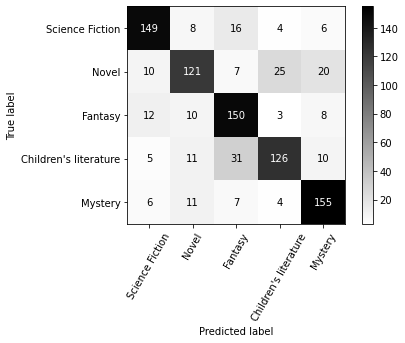

In [ ]:
rus_test = RandomUnderSampler(random_state=666)
df_test_rus,_ = rus_test.fit_resample(df_test,df_test['Genre_Class'].tolist())

print(df_test_rus['Genre_Class'].value_counts())

y_pred_NMI = train_classifier_NMI.predict(np.array(df_test_rus['Embedding'].tolist()))


cm_NMI = confusion_matrix(np.array(df_test_rus['Genre_Class'].tolist()), y_pred_NMI)
ac_NMI = accuracy_score(np.array(df_test_rus['Genre_Class'].tolist()),y_pred_NMI)

print(cm_NMI)
print(ac_NMI)

print(precision_score(np.array(df_test_rus['Genre_Class'].tolist()), y_pred, average=None))
print(recall_score(np.array(df_test_rus['Genre_Class'].tolist()), y_pred, average=None))
print(f1_score(np.array(df_test_rus['Genre_Class'].tolist()), y_pred, average=None))

disp = ConfusionMatrixDisplay.from_predictions(np.array(df_test_rus['Genre_Class'].tolist()), y_pred_NMI, display_labels=selected_genres, xticks_rotation=60, cmap="gist_yarg")


In [ ]:
def model_builder(hp):
    model = tf.keras.Sequential()
    

    hp_units_1 = hp.Int('units_1', min_value=32, max_value=128, step=32)
    hp_choice_1 = hp.Choice('activation_1', ["relu","tanh","sigmoid"])
    model.add(keras.layers.Dense(units=hp_units_1, activation=hp_choice_1, input_shape = (len(df_train['Embedding'][0]),)))

    hp_units_2 = hp.Int('units_2', min_value=32, max_value=128, step=32)
    hp_choice_2 = hp.Choice('activation_2', ["relu","tanh","sigmoid"])
    model.add(keras.layers.Dense(units=hp_units_2, activation=hp_choice_2))

    model.add(keras.layers.Dense(5, activation="softmax"))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    metrics = [
        keras.metrics.CategoricalAccuracy(name="categorical_accuracy"),
        keras.metrics.FalseNegatives(name="fn"),
        keras.metrics.FalsePositives(name="fp"),
        keras.metrics.TrueNegatives(name="tn"),
        keras.metrics.TruePositives(name="tp"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ]

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=metrics)

    return model


tuner = kt.Hyperband(model_builder,
                     objective='val_categorical_accuracy',
                     max_epochs=200,
                     factor=3,
                     directory='/content/drive/MyDrive/TCC/',
                     project_name='intro_to_kt')


tuner.search(np.array(df_train['Embedding'].tolist()), np.array(df_train['ohe_train'].tolist()), epochs=50, validation_split=0.2)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first densely-connected
layer is {best_hps.get('units_1')}, activation {best_hps.get('activation_1')}

The optimal number of units in the Second densely-connected
layer is {best_hps.get('units_1')}, activation {best_hps.get('activation_1')} 

And the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")





INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/TCC/intro_to_kt/oracle.json


INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/TCC/intro_to_kt/oracle.json


INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/TCC/intro_to_kt/tuner0.json


INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/TCC/intro_to_kt/tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



The hyperparameter search is complete. 
The optimal number of units in the first densely-connected
layer is 96, activation relu

The optimal number of units in the Second densely-connected
layer is 96, activation relu 

And the optimal learning rate for the optimizer is 0.0001.



In [ ]:
model = tuner.hypermodel.build(best_hps)


hist_model = model.fit(np.array(df_train['Embedding'].tolist()), np.array(df_train['ohe_train'].tolist()),
                       batch_size=32,
                       epochs=100,
                       verbose=0,
                       validation_data=(np.array(df_test['Embedding'].tolist()), np.array(df_test['ohe_test'].tolist())))

model.save('/content/drive/MyDrive/TCC/modelo-NN')




INFO:tensorflow:Assets written to: /content/drive/MyDrive/TCC/modelo-NN/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TCC/modelo-NN/assets


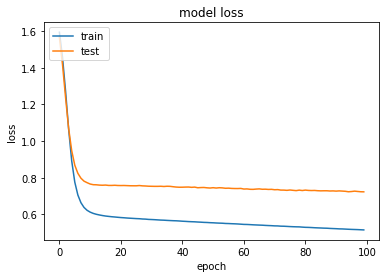

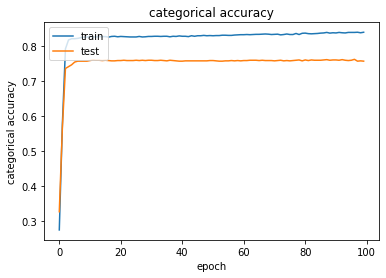

36/36 [==============================] - 0s 4ms/step - loss: 0.7233 - categorical_accuracy: 0.7578 - fn: 295.0000 - fp: 239.0000 - tn: 4353.0000 - tp: 853.0000 - precision: 0.7811 - recall: 0.7430
---------------
Perda (entropia cruzada):  0.7232604622840881
Categorical accuracy:  0.7578397393226624
Falsos negativos:  295.0
Falsos positivos:  239.0
Verdadeiros negativos:  4353.0
Verdadeiros positivos:  853.0
Precisao:  0.7811355590820312
Revocacao:  0.74303138256073


In [ ]:
plt.plot(hist_model.history["loss"])
plt.plot(hist_model.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

plt.plot(hist_model.history["categorical_accuracy"])
plt.plot(hist_model.history["val_categorical_accuracy"])
plt.title("categorical accuracy")
plt.ylabel("categorical accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()




In [ ]:
modelNN = keras.models.load_model('/content/drive/MyDrive/TCC/modelo-NN')

score = modelNN.evaluate(np.array(df_test['Embedding'].tolist()), np.array(df_test['ohe_test'].tolist()))
print('---------------')
print("Perda (entropia cruzada): ", score[0])
print("Categorical accuracy: ", score[1])
print("Falsos negativos: ", score[2])
print("Falsos positivos: ", score[3])
print("Verdadeiros negativos: ", score[4])
print("Verdadeiros positivos: ", score[5])
print("Precisao: ", score[6])
print("Revocacao: ", score[7])


36/36 [==============================] - 2s 4ms/step - loss: 0.7233 - categorical_accuracy: 0.7578 - fn: 295.0000 - fp: 239.0000 - tn: 4353.0000 - tp: 853.0000 - precision: 0.7811 - recall: 0.7430
---------------
Perda (entropia cruzada):  0.7232604622840881
Categorical accuracy:  0.7578397393226624
Falsos negativos:  295.0
Falsos positivos:  239.0
Verdadeiros negativos:  4353.0
Verdadeiros positivos:  853.0
Precisao:  0.7811355590820312
Revocacao:  0.74303138256073


0    183
1    183
2    183
3    183
4    183
Name: Genre_Class, dtype: int64
[2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 4 3 0 0 0 0 2 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 0 1 0 4 0 0 0 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 4 0 0 0 0 0 0 0 2 0 0 0 3 0 0 0 2 0 0 0 4 2 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 3 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 0 0 2 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 1 3 4 1 1 1 4 1 1 1 2 1 1 3 1 2 1 1 3 1 1 4 0 1 3 3 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 1 1 1 1 1 1 1 1 3 1 1 1 1 3 0 1 1 3 3 3 1 1 2 1 4 0 1 1 0 1 3 4 1 3 4 1 1 1 1 1 1 4 1 3 1 1 1 1 1 1 0 1 1 3 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 4 4 4 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 0 3 1 1 1 1 1 1 1 1 0 1 3 1 3 1 1 1 1 3 1 1 3 1 4 1 1 1 3 1 1 1 3 1 2 1 3 2 1 3 1 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 1 2 2 2 0 2 2 2 2 3 2 2 2 2 4 2 2 0 2 1 2 2 2 2 2 0 2 2 0 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 3 2 2 1 2 2 0 2 2 2 1 2 2 2 2 0 0 2 2 2 2 2 2 2 2 

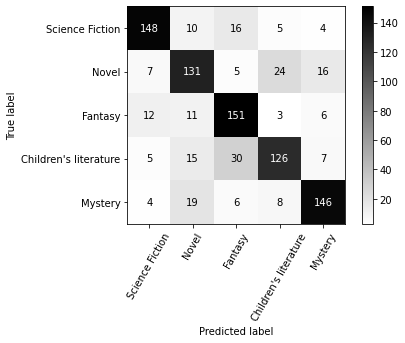

In [ ]:

rus_test = RandomUnderSampler(random_state=666)
df_test_rus,_ = rus_test.fit_resample(df_test,df_test['Genre_Class'].tolist())

print(df_test_rus['Genre_Class'].value_counts())

pred = modelNN.predict(np.array(df_test_rus['Embedding'].tolist()))

print(np.argmax(pred, axis=1))

cm_NN = confusion_matrix(np.array(df_test_rus['Genre_Class'].tolist()), np.argmax(pred, axis=1))
ac_NN = accuracy_score(np.array(df_test_rus['Genre_Class'].tolist()),np.argmax(pred, axis=1))

print(cm_NN)
print(ac_NN)

print(precision_score(np.array(df_test_rus['Genre_Class'].tolist()), np.argmax(pred, axis=1), average=None))
print(recall_score(np.array(df_test_rus['Genre_Class'].tolist()), np.argmax(pred, axis=1), average=None))
print(f1_score(np.array(df_test_rus['Genre_Class'].tolist()), np.argmax(pred, axis=1), average=None))

disp = ConfusionMatrixDisplay.from_predictions(np.array(df_test_rus['Genre_Class'].tolist()), np.argmax(pred, axis=1), display_labels=selected_genres, xticks_rotation=60, cmap="gist_yarg")


In [ ]:
import time
for i in range(100000):
    time.sleep(60)
    print('derp')

derp
derp
derp
derp
derp
derp
derp
derp
derp
derp
derp
derp
derp
derp
derp
derp
derp
derp
derp
derp
derp
derp
derp
derp
derp


KeyboardInterrupt: ignored